# --- Zillow project: Home value prediction --- 

# Part 1: Data Preparing

In [16]:
# import packages for further use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Get raw data

The dataset we will use is the Zillow Zestimate Home value prediction in Kaggle competition.  

In [2]:
!ls -lh raw_data

total 1.3G
-rw-r--r-- 1 admin 197121 619M Jun 20  2018 properties_2016.csv
-rw-r--r-- 1 admin 197121 620M Jun 20  2018 properties_2017.csv
-rw-r--r-- 1 admin 197121 2.4M Jun 20  2018 train_2016_v2.csv
-rw-r--r-- 1 admin 197121 2.7M Jun 20  2018 train_2017.csv
-rw-r--r-- 1 admin 197121  19K Jun 20  2018 zillow_data_dictionary.xlsx


So we have 5 files from kaggle that are including both properties and train files for 2016 and 2017, and one dictionary file that explain the meaning of the features variables in the data files.

# Load data

In [3]:
# reading data and get the dimensionality of the data
dictionary = pd.read_excel('raw_data/zillow_data_dictionary.xlsx')
print(dictionary.shape)
dictionary.head()

(58, 2)


,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home


Setting up some functions for further use:

In [42]:
def Load_data(dataset, verbose=False):
    '''load one of Zillow dataset'''
    df = pd.read_csv('raw_data/{0}.csv'.format(dataset))
    
    if verbose:
        print('\n{0:*^80}'.format('In {0} dataset'.format(dataset)))
        print('\nit has {0} rows and {1} columns'.format(*df.shape))
        print('\n{0:*^80}'.format(' The columns are'))
        print(df.columns)
        print('\n{0:*^80}'.format(' The top 5 rows are'))
        print(df.head())
    
    return df

def select_per_parcel(df):
    '''drop duplicated to only record for each unique parcel'''
    
    count_per_parcel = df.groupby('parcelid').size()
    more_than_one = df[df.parcelid.isin(count_per_parcel[count_per_parcel > 1].index)]
    only_one = df[df.parcelid.isin(count_per_parcel[count_per_parcel == 1].index)]
    selected_more_than_one = more_than_one.sort_values(by='transactiondate', ascending=False).groupby('parcelid').head(1)
    All_unique_df = pd.concat([only_one, selected_more_than_one])
    
    print(All_unique_df.shape)
    return All_unique_df

def get_data(dataset):
    '''create training dataset 2016 or the test dataset 2017'''
    
    year = {'train': 2016, 'test': 2017}[dataset]
    train = Load_data('train_{0}'.format(year))
    properties = Load_data('properties_{0}'.format(year))
    merge_data = pd.merge(train, properties, how='left', on='parcelid')
    
    if dataset =='train':
        merge_data = de_dup_per_parcel(merge_data)
        
    new_merge = merge_data.pop('logerror')
    return merge_data, new_merge

def mean_absolute_error(new_merge_real, new_merge_predict):
    return np.mean(np.abs(new_merge_real - new_merge_predict))   

In [5]:
properties = Load_data('properties_2016', verbose=True)

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2901: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):



***************************In properties_2016 dataset***************************

it has 2985217 rows and 58 columns

******************************** The columns are********************************
Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity'

In [6]:
train_raw = Load_data('train_2016', verbose=True)


****************************In train_2016_v2 dataset****************************

it has 90275 rows and 3 columns

******************************** The columns are********************************
Index(['parcelid', 'logerror', 'transactiondate'], dtype='object')

****************************** The top 5 rows are*******************************
   parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02


# EDA 

In [7]:
# how many train records don't have a matching property
len(set(train_raw.parcelid) - set(properties.parcelid))

0

In [8]:
# how many properties don't have a matching train record
len(set(properties.parcelid) - set(train_raw.parcelid))

2895067

Therefore, number of properties have no corresponding record. Now, we only keep those properties which has corresponding records.

In [9]:
train_merged_properties = pd.merge(train_raw, properties, how='left', on='parcelid')
del train_raw
del properties

In [10]:
train_merged_properties.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [11]:
train_merged_properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
transactiondate                 90275 non-null object
airconditioningtypeid           28781 non-null float64
architecturalstyletypeid        261 non-null float64
basementsqft                    43 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
buildingclasstypeid             16 non-null float64
buildingqualitytypeid           57364 non-null float64
calculatedbathnbr               89093 non-null float64
decktypeid                      658 non-null float64
finishedfloor1squarefeet        6856 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
finishedsquarefeet12            85596 non-null float64
finishedsquarefeet13            33 non-null float64
finishedsquarefeet15        

Converting datatime to datetime datetype and validating date range

2016-12-30 00:00:00
2016-01-01 00:00:00


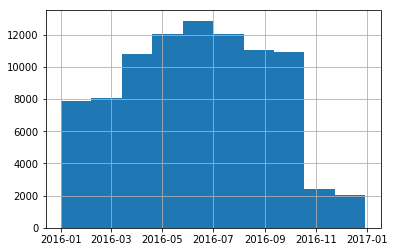

In [12]:
pd.to_datetime(train_merged_properties.transactiondate).hist()
print(pd.to_datetime(train_merged_properties.transactiondate).max())
print(pd.to_datetime(train_merged_properties.transactiondate).min())

# Duplicate parcels

Check if every parcel has only one corresponded record 

In [13]:
count_per_parcel = train_merged_properties.groupby('parcelid').size()
more_than_one = train_merged_properties[train_merged_properties.parcelid.isin(count_per_parcel[count_per_parcel > 1].index)]
only_one = train_merged_properties[train_merged_properties.parcelid.isin(count_per_parcel[count_per_parcel == 1].index)]

In [14]:
print(more_than_one.parcelid.nunique())

124


In [15]:
more_than_one.head(10)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
496,13850164,-0.1567,2016-01-05,13.0,NaN,NaN,2.0,3.0,NaN,NaN,...,1.0,NaN,76740.0,260828.0,2015.0,184088.0,3079.84,NaN,NaN,6.059001e+13
497,13850164,-0.0460,2016-06-29,13.0,NaN,NaN,2.0,3.0,NaN,NaN,...,1.0,NaN,76740.0,260828.0,2015.0,184088.0,3079.84,NaN,NaN,6.059001e+13
781,14677191,-0.3682,2016-01-06,1.0,NaN,NaN,2.0,2.0,NaN,NaN,...,1.0,NaN,95488.0,234504.0,2015.0,139016.0,2467.90,NaN,NaN,6.059063e+13
782,14677191,-0.0845,2016-09-12,1.0,NaN,NaN,2.0,2.0,NaN,NaN,...,1.0,NaN,95488.0,234504.0,2015.0,139016.0,2467.90,NaN,NaN,6.059063e+13
813,11005771,-0.0131,2016-01-06,NaN,NaN,NaN,2.0,5.0,NaN,4.0,...,NaN,NaN,56889.0,75221.0,2015.0,18332.0,1134.10,NaN,NaN,6.037101e+13
814,11005771,0.0545,2016-06-17,NaN,NaN,NaN,2.0,5.0,NaN,4.0,...,NaN,NaN,56889.0,75221.0,2015.0,18332.0,1134.10,NaN,NaN,6.037101e+13
967,11183209,-0.0481,2016-01-07,1.0,NaN,NaN,3.0,4.0,NaN,4.0,...,NaN,NaN,222215.0,275555.0,2015.0,53340.0,4375.10,NaN,NaN,6.037910e+13
968,11183209,-0.0070,2016-09-14,1.0,NaN,NaN,3.0,4.0,NaN,4.0,...,NaN,NaN,222215.0,275555.0,2015.0,53340.0,4375.10,NaN,NaN,6.037910e+13
1164,11554091,-0.1696,2016-01-07,NaN,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,208376.0,437155.0,2015.0,228779.0,5448.05,NaN,NaN,6.037272e+13
1165,11554091,-0.0954,2016-07-05,NaN,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,208376.0,437155.0,2015.0,228779.0,5448.05,NaN,NaN,6.037272e+13


---Discussions---

From this dataframe, we found that there are 124 unique parcelid have more than one records which refers to some Home were transacted not only onces during the period from 2016-12-30 to 2016-01-01 (timestamp check from previous step). 

Thus, we need to select one record for each parcelid as unique record.

Since the valuable features in the dataframe are consistant for each unique parcelid(home unit), the only differnce between records for same Home unit is the transaction date variable.

Therefore, there are some ways to select the record for training our model:
    1. Use the latest transaction date record
    2. Use the earliest transaction date record
    3. Randomly choose one for each parcelid

In overview, there are 124 parcelid has more than one sales record over 90275 entries. Therefore, we can say that the method of choosing representative one from those record would not be significantly affect our model. Thus, personally, I decided to choose the latest record for each parcelid as the unique record

---

In [20]:
# Double check the two part of dataframe completely seperate the original df
assert len(train_merged_properties) == (len(more_than_one) + len(only_one))

In [43]:
select_per_parcel(train_merged_properties)

(90150, 60)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,1.0,NaN,NaN,4.0,4.0,NaN,1.0,...,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.57,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,7.0,...,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.97,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,NaN,NaN,NaN,2.5,3.0,NaN,NaN,...,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.50,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.88,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,1.0,NaN,109977.0,190960.0,2015.0,80983.0,1940.26,NaN,NaN,6.059063e+13


In [44]:
# testing if the unique parcelid in new df is same as the original df from Kaggle 
assert set(train_merged_properties.parcelid) == set(All_unique_df.parcelid)

# Check Target variable -- Logerror

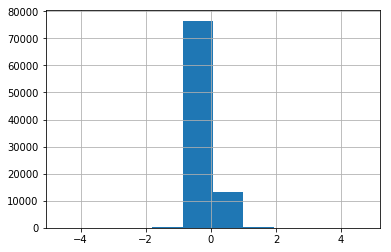

In [47]:
All_unique_df.logerror.hist()

By ploting the logerror in a histogram, we observed a likely Laplace distribution. Thus, we could apply the log function on density, the distribution would looks like a normal distribution. 

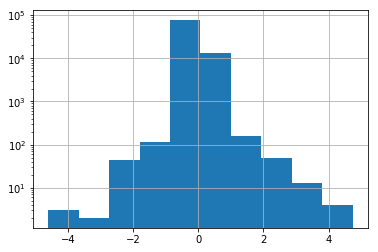

In [48]:
fig, ax = plt.subplots()
All_unique_df.logerror.hist(ax=ax)
ax.set_yscale('log')

#  Null values info:

In [50]:
All_unique_df.isnull().sum().sort_values(ascending=False).head(20)

buildingclasstypeid         90134
finishedsquarefeet13        90117
basementsqft                90107
storytypeid                 90107
yardbuildingsqft26          90055
fireplaceflag               89930
architecturalstyletypeid    89890
typeconstructiontypeid      89852
finishedsquarefeet6         89731
decktypeid                  89492
poolsizesum                 89184
pooltypeid10                88991
pooltypeid2                 88946
taxdelinquencyyear          88375
taxdelinquencyflag          88375
hashottuborspa              87787
yardbuildingsqft17          87505
finishedsquarefeet15        86595
finishedsquarefeet50        83300
finishedfloor1squarefeet    83300
dtype: int64

In [54]:
All_unique_df.isnull().sum().sort_values(ascending=True).head(20)

parcelid                        0
longitude                       0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcounty                  0
roomcnt                         0
latitude                        0
fips                            0
bathroomcnt                     0
assessmentyear                  0
transactiondate                 0
logerror                        0
bedroomcnt                      0
taxvaluedollarcnt               1
landtaxvaluedollarcnt           1
propertycountylandusecode       1
taxamount                       6
regionidzip                    35
structuretaxvaluedollarcnt    378
censustractandblock           603
dtype: int64

# Check if certain column has same values

1. After explore the Null values, we also want to check our columns if they have same values. If so, we won't need them to include in our model.
2. what if some of features has high cardinality? If so, we also won't need to include them in our model since they don't have high valuable information. 

In [52]:
All_unique_df.nunique().sort_values(ascending=False).head(30)

parcelid                        90150
taxamount                       85110
latitude                        73312
longitude                       71900
landtaxvaluedollarcnt           57066
taxvaluedollarcnt               55938
structuretaxvaluedollarcnt      55450
rawcensustractandblock          42647
censustractandblock             42398
lotsizesquarefeet               20016
calculatedfinishedsquarefeet     5102
finishedsquarefeet12             4982
propertyzoningdesc               1996
finishedsquarefeet15             1915
finishedsquarefeet50             1898
logerror                         1893
finishedfloor1squarefeet         1886
garagetotalsqft                   870
yardbuildingsqft17                567
regionidneighborhood              494
regionidzip                       388
finishedsquarefeet6               360
transactiondate                   352
poolsizesum                       273
regionidcity                      177
yearbuilt                         130
propertycoun

Varaibles with high cardinality: 
    
1. rawcensustractandblock          
2. censustractandblock
3. propertyzoningdesc
4. regionidneighborhood
5. regionidneighborhood         

In [55]:
All_unique_df.nunique(dropna=False).sort_values(ascending=True).head(15)

assessmentyear            1
poolcnt                   2
storytypeid               2
fireplaceflag             2
pooltypeid7               2
pooltypeid2               2
buildingclasstypeid       2
pooltypeid10              2
decktypeid                2
taxdelinquencyflag        2
hashottuborspa            2
regionidcounty            3
fips                      3
typeconstructiontypeid    4
threequarterbathnbr       5
dtype: int64

Therefore, the feature variable 'assessmentyear' has only one unique value. We can drop it while modeling.